Data Preparation

In [1]:
import os

base_dir = "ds_jiji_babu"

folders = [
    base_dir,
    f"{base_dir}/csv_files",
    f"{base_dir}/outputs"
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

print("Directory structure created successfully")

Directory structure created successfully


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
fear_grid = pd.read_csv("/content/ds_jiji_babu/csv_files/fear_greed_index.csv")
hyperliquid = pd.read_csv("/content/ds_jiji_babu/csv_files/historical_data.csv")

In [4]:
print("Rows :", fear_grid.shape[0])
print("Columns :", fear_grid.shape[1])

print("Rows :", hyperliquid.shape[0])
print("Columns :", hyperliquid.shape[1])

Rows : 2644
Columns : 4
Rows : 211224
Columns : 16


In [5]:
print("Missing values :", fear_grid.isnull().sum().sum())
print("Missing values :", hyperliquid.isnull().sum().sum())

Missing values : 0
Missing values : 0


In [6]:
print("Duplicate", fear_grid.duplicated().sum())
print("Duplicate", hyperliquid.duplicated().sum())

Duplicate 0
Duplicate 0


In [7]:
fear_grid.info()
hyperliquid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-nu

In [67]:
fear_grid.columns
hyperliquid.columns

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'date'],
      dtype='object')

Convert timestamp columns

In [10]:
fear_grid["timestamp"] = pd.to_datetime(fear_grid["timestamp"], errors="coerce")
hyperliquid["Timestamp"] = pd.to_datetime(hyperliquid["Timestamp"], errors="coerce")

Create daily date column

In [11]:
fear_grid["date"] = fear_grid["timestamp"].dt.floor("D")
hyperliquid["date"] = hyperliquid["Timestamp"].dt.floor("D")

In [ ]:
Fear_grid daily (numeric values)

In [12]:
fear_daily = (
    fear_grid.groupby("date")["value"]
    .mean()
    .reset_index()
)

Hyperliquid daily (Pnl,fees,volume)

In [13]:
hyper_daily = (
    hyperliquid.groupby("date")
    .agg(
        total_trades=("Trade ID", "count"),
        total_volume_usd=("Size USD", "sum"),
        total_fees=("Fee", "sum"),
        total_pnl=("Closed PnL", "sum")
    )
    .reset_index()
)


Merging

In [14]:
merged_daily = pd.merge(fear_daily, hyper_daily, on="date", how="inner")

print("Fear daily shape:", fear_daily.shape)
print("Hyperliquid daily shape:", hyper_daily.shape)
print("Merged daily shape:", merged_daily.shape)


Fear daily shape: (1, 2)
Hyperliquid daily shape: (1, 5)
Merged daily shape: (1, 6)


In [15]:
print(merged_daily.head())

        date      value  total_trades  total_volume_usd     total_fees  \
0 1970-01-01  46.981089        211224      1.191187e+09  245857.720566   

      total_pnl  
0  1.029696e+07  


Daily metrics per account - PnL

In [16]:
hyper_account_daily = (
    hyperliquid.groupby(["date", "Account"])
    .agg(
        trades=("Trade ID", "count"),
        total_pnl=("Closed PnL", "sum"),
        avg_trade_size_usd=("Size USD", "mean"),
        total_volume_usd=("Size USD", "sum"),
        total_fees=("Fee", "sum"),
        wins=("Closed PnL", lambda x: (x > 0).sum()),
        losses=("Closed PnL", lambda x: (x < 0).sum())
    )
    .reset_index()
)

hyper_account_daily["win_rate"] = hyper_account_daily["wins"] / hyper_account_daily["trades"]

print(hyper_account_daily.head())


        date                                     Account  trades  \
0 1970-01-01  0x083384f897ee0f19899168e3b1bec365f52a9012    3818   
1 1970-01-01  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd    7280   
2 1970-01-01  0x271b280974205ca63b716753467d5a371de622ab    3809   
3 1970-01-01  0x28736f43f1e871e6aa8b1148d38d4994275d72c4   13311   
4 1970-01-01  0x2c229d22b100a7beb69122eed721cee9b24011dd    3239   

      total_pnl  avg_trade_size_usd  total_volume_usd   total_fees  wins  \
0  1.600230e+06        16159.576734       61697263.97  7405.312304  1373   
1  4.788532e+04         1653.226327       12035487.66  2729.837889  3223   
2 -7.043619e+04         8893.000898       33873440.42  9280.982850  1150   
3  1.324648e+05          507.626933        6757022.10  2218.367366  5838   
4  1.686580e+05         3138.894782       10166880.20  3108.196722  1684   

   losses  win_rate  
0     359  0.359612  
1     943  0.442720  
2     457  0.301917  
3     934  0.438585  
4     376  0.519914  


Overall daily metrics

In [17]:
hyper_daily_metrics = (
    hyperliquid.groupby("date")
    .agg(
        trades=("Trade ID", "count"),
        total_pnl=("Closed PnL", "sum"),
        avg_trade_size_usd=("Size USD", "mean"),
        total_volume_usd=("Size USD", "sum"),
        total_fees=("Fee", "sum"),
        unique_accounts=("Account", "nunique"),
        wins=("Closed PnL", lambda x: (x > 0).sum())
    )
    .reset_index()
)

hyper_daily_metrics["win_rate"] = hyper_daily_metrics["wins"] / hyper_daily_metrics["trades"]

print(hyper_daily_metrics.head())


        date  trades     total_pnl  avg_trade_size_usd  total_volume_usd  \
0 1970-01-01  211224  1.029696e+07          5639.45121      1.191187e+09   

      total_fees  unique_accounts   wins  win_rate  
0  245857.720566               32  86869  0.411265  


Daily Long / Short ratio

In [18]:
ls_daily = (
    hyperliquid.groupby(["date", "Side"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

if "Buy" in ls_daily.columns and "Sell" in ls_daily.columns:
    ls_daily["long_short_ratio"] = ls_daily["Buy"] / ls_daily["Sell"].replace(0, np.nan)

print(ls_daily.head())


Side       date     BUY    SELL
0    1970-01-01  102696  108528


Leverage distribution

In [19]:
leverage_proxy = hyperliquid[["Account", "Start Position"]].dropna()

print(leverage_proxy["Start Position"].describe())

leverage_proxy_account = (
    hyperliquid.groupby("Account")["Start Position"]
    .mean()
    .reset_index(name="avg_start_position")
)

print(leverage_proxy_account.head())


count    2.112240e+05
mean    -2.994625e+04
std      6.738074e+05
min     -1.433463e+07
25%     -3.762311e+02
50%      8.472793e+01
75%      9.337278e+03
max      3.050948e+07
Name: Start Position, dtype: float64
                                      Account  avg_start_position
0  0x083384f897ee0f19899168e3b1bec365f52a9012        -1247.334684
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd        11181.808655
2  0x271b280974205ca63b716753467d5a371de622ab       -10248.195171
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4        17817.982104
4  0x2c229d22b100a7beb69122eed721cee9b24011dd       472411.528070


Number of trades per day

In [20]:
trades_per_day = (
    hyperliquid.groupby("date")
    .size()
    .reset_index(name="trades_per_day")
)

print(trades_per_day.head())


        date  trades_per_day
0 1970-01-01          211224


Analysis

Fear_grid daily data

In [21]:
fear_daily = (
    fear_grid.groupby("date")
    .agg(
        fear_value=("value", "mean"),
        fear_class=("classification", lambda x: x.mode()[0] if len(x.mode()) > 0 else None)
    )
    .reset_index()
)

fear_daily.head()

,date,fear_value,fear_class
0,1970-01-01,46.981089,Fear


Hyperliquid daily metrics

In [23]:
hyperliquid["Timestamp"] = pd.to_datetime(hyperliquid["Timestamp"], errors="coerce")
hyperliquid["date"] = hyperliquid["Timestamp"].dt.floor("D")

hyperliquid["Closed PnL"] = pd.to_numeric(hyperliquid["Closed PnL"], errors="coerce")
hyperliquid["Size USD"] = pd.to_numeric(hyperliquid["Size USD"], errors="coerce")

hyper_daily = (
    hyperliquid.groupby("date")
    .agg(
        daily_pnl=("Closed PnL", "sum"),
        trades=("Trade ID", "count"),
        avg_trade_size=("Size USD", "mean"),
        wins=("Closed PnL", lambda x: (x > 0).sum())
    )
    .reset_index()
)

hyper_daily["win_rate"] = hyper_daily["wins"] / hyper_daily["trades"]
hyper_daily.head()


,date,daily_pnl,trades,avg_trade_size,wins,win_rate
0,1970-01-01,1.029696e+07,211224,5639.45121,86869,0.411265


daily Drawndown proxy

In [24]:
merged = pd.merge(hyper_daily, fear_daily, on="date", how="inner").sort_values("date")

merged["cum_pnl"] = merged["daily_pnl"].cumsum()
merged["rolling_peak"] = merged["cum_pnl"].cummax()
merged["drawdown"] = merged["cum_pnl"] - merged["rolling_peak"]   # negative values
merged["drawdown_pct_proxy"] = merged["drawdown"] / merged["rolling_peak"].replace(0, np.nan)

merged[["date", "daily_pnl", "win_rate", "fear_class", "fear_value", "drawdown"]].head()


,date,daily_pnl,win_rate,fear_class,fear_value,drawdown
0,1970-01-01,1.029696e+07,0.411265,Fear,46.981089,0.0


Fear vs Greed days

In [25]:
def simplify_class(x):
    if pd.isna(x):
        return np.nan
    x = str(x).lower()
    if "fear" in x:
        return "Fear"
    if "greed" in x:
        return "Greed"
    return "Neutral"

merged["FG_group"] = merged["fear_class"].apply(simplify_class)
merged["FG_group"].value_counts(dropna=False)


,count
FG_group,
Fear,1


Compare metrics

In [26]:
summary = (
    merged.groupby("FG_group")
    .agg(
        days=("date", "count"),
        avg_daily_pnl=("daily_pnl", "mean"),
        median_daily_pnl=("daily_pnl", "median"),
        avg_win_rate=("win_rate", "mean"),
        avg_drawdown=("drawdown", "mean"),
        worst_drawdown=("drawdown", "min"),
        avg_trades=("trades", "mean")
    )
    .reset_index()
)

summary


,FG_group,days,avg_daily_pnl,median_daily_pnl,avg_win_rate,avg_drawdown,worst_drawdown,avg_trades
0,Fear,1,1.029696e+07,1.029696e+07,0.411265,0.0,0.0,211224.0


Fear_Grid statistical test

In [27]:
from scipy.stats import ttest_ind, mannwhitneyu

fear_days = merged[merged["FG_group"] == "Fear"]
greed_days = merged[merged["FG_group"] == "Greed"]

t_pnl = ttest_ind(fear_days["daily_pnl"].dropna(), greed_days["daily_pnl"].dropna(), equal_var=False)

t_wr = ttest_ind(fear_days["win_rate"].dropna(), greed_days["win_rate"].dropna(), equal_var=False)

t_dd = ttest_ind(fear_days["drawdown"].dropna(), greed_days["drawdown"].dropna(), equal_var=False)

print("T-Test Results (Fear vs Greed):")
print("Daily PnL:", t_pnl)
print("Win Rate:", t_wr)
print("Drawdown:", t_dd)

mw_pnl = mannwhitneyu(fear_days["daily_pnl"].dropna(), greed_days["daily_pnl"].dropna(), alternative="two-sided")
mw_wr = mannwhitneyu(fear_days["win_rate"].dropna(), greed_days["win_rate"].dropna(), alternative="two-sided")
mw_dd = mannwhitneyu(fear_days["drawdown"].dropna(), greed_days["drawdown"].dropna(), alternative="two-sided")

print("\nMann–Whitney U Results:")
print("Daily PnL:", mw_pnl)
print("Win Rate:", mw_wr)
print("Drawdown:", mw_dd)


T-Test Results (Fear vs Greed):
Daily PnL: TtestResult(statistic=np.float64(nan), pvalue=np.float64(nan), df=np.float64(nan))
Win Rate: TtestResult(statistic=np.float64(nan), pvalue=np.float64(nan), df=np.float64(nan))
Drawdown: TtestResult(statistic=np.float64(nan), pvalue=np.float64(nan), df=np.float64(nan))

Mann–Whitney U Results:
Daily PnL: MannwhitneyuResult(statistic=np.float64(nan), pvalue=np.float64(nan))
Win Rate: MannwhitneyuResult(statistic=np.float64(nan), pvalue=np.float64(nan))
Drawdown: MannwhitneyuResult(statistic=np.float64(nan), pvalue=np.float64(nan))


/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/tmp/ipython-input-2452944310.py:17: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  mw_pnl = mannwhitneyu(fear_days["daily_pnl"].dropna(), greed_days["daily_pnl"].dropna(), alternative="two-sided")
/tmp/ipython-input-2452944310.py:18: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  mw_wr = mannwhitneyu(fear_days["win_rate"].dropna(), greed_days["win_rate"].dropna(), alternative="two-sided")
/tmp/ipython-input-2452944310.py:19: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size

Merge fear_grid into Hyperliquid trades

In [28]:
fear_daily["FG_group"] = fear_daily["fear_class"].apply(simplify_class)

In [29]:
for col in ["Size USD", "Closed PnL", "Fee", "Start Position"]:
    if col in hyperliquid.columns:
        hyperliquid[col] = pd.to_numeric(hyperliquid[col], errors="coerce")

In [30]:
hyper_sent = pd.merge(hyperliquid, fear_daily[["date", "fear_value", "FG_group"]], on="date", how="inner")

hyper_sent.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date,fear_value,FG_group
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1970-01-01 00:28:50,1970-01-01,46.981089,Fear
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1970-01-01 00:28:50,1970-01-01,46.981089,Fear
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1970-01-01 00:28:50,1970-01-01,46.981089,Fear
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1970-01-01 00:28:50,1970-01-01,46.981089,Fear
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1970-01-01 00:28:50,1970-01-01,46.981089,Fear


Fear_Greed behavioral metrics by sentiment

In [31]:
freq_by_sentiment = (
    hyper_sent.groupby(["date", "FG_group"])
    .size()
    .reset_index(name="trades_per_day")
)

freq_summary = (
    freq_by_sentiment.groupby("FG_group")
    .agg(
        days=("date", "nunique"),
        avg_trades_per_day=("trades_per_day", "mean"),
        median_trades_per_day=("trades_per_day", "median")
    )
    .reset_index()
)

freq_summary


,FG_group,days,avg_trades_per_day,median_trades_per_day
0,Fear,1,211224.0,211224.0


Average position size (Size USD)

In [32]:
size_summary = (
    hyper_sent.groupby("FG_group")
    .agg(
        trades=("Trade ID", "count"),
        avg_trade_size_usd=("Size USD", "mean"),
        median_trade_size_usd=("Size USD", "median"),
        total_volume_usd=("Size USD", "sum")
    )
    .reset_index()
)

size_summary


,FG_group,trades,avg_trade_size_usd,median_trade_size_usd,total_volume_usd
0,Fear,211224,5639.45121,597.045,1.191187e+09


Long / Short ratio bias

In [33]:
ls_counts = (
    hyper_sent.groupby(["FG_group", "Side"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

if "Buy" in ls_counts.columns and "Sell" in ls_counts.columns:
    ls_counts["long_short_ratio"] = ls_counts["Buy"] / ls_counts["Sell"].replace(0, np.nan)

ls_counts


Side,FG_group,BUY,SELL
0,Fear,102696,108528


Proxy leverage behavior

In [34]:
leverage_proxy_summary = (
    hyper_sent.groupby("FG_group")
    .agg(
        avg_start_position=("Start Position", "mean"),
        median_start_position=("Start Position", "median"),
        max_start_position=("Start Position", "max")
    )
    .reset_index()
)

leverage_proxy_summary


,FG_group,avg_start_position,median_start_position,max_start_position
0,Fear,-29946.248839,84.727932,30509482.0


Pre-account behavior change

In [35]:
account_daily_behavior = (
    hyper_sent.groupby(["date", "Account", "FG_group"])
    .agg(
        trades=("Trade ID", "count"),
        avg_trade_size=("Size USD", "mean"),
        total_volume=("Size USD", "sum"),
        avg_start_position=("Start Position", "mean")
    )
    .reset_index()
)

account_daily_behavior.head()


,date,Account,FG_group,trades,avg_trade_size,total_volume,avg_start_position
0,1970-01-01,0x083384f897ee0f19899168e3b1bec365f52a9012,Fear,3818,16159.576734,61697263.97,-1247.334684
1,1970-01-01,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,Fear,7280,1653.226327,12035487.66,11181.808655
2,1970-01-01,0x271b280974205ca63b716753467d5a371de622ab,Fear,3809,8893.000898,33873440.42,-10248.195171
3,1970-01-01,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,Fear,13311,507.626933,6757022.10,17817.982104
4,1970-01-01,0x2c229d22b100a7beb69122eed721cee9b24011dd,Fear,3239,3138.894782,10166880.20,472411.528070


Fear_Grid statistical test

In [36]:
from scipy.stats import mannwhitneyu

fear = hyper_sent[hyper_sent["FG_group"] == "Fear"]
greed = hyper_sent[hyper_sent["FG_group"] == "Greed"]

def mw_test(col):
    x = fear[col].dropna()
    y = greed[col].dropna()
    if len(x) < 5 or len(y) < 5:
        return None
    return mannwhitneyu(x, y, alternative="two-sided")

print("Mann–Whitney Tests (Fear vs Greed)")
print("Trade size:", mw_test("Size USD"))
print("Start Position (proxy leverage):", mw_test("Start Position"))


Mann–Whitney Tests (Fear vs Greed)
Trade size: None
Start Position (proxy leverage): None


Daily aggregated trade count

In [37]:
daily_trades = (
    hyper_sent.groupby(["date", "FG_group"])
    .size()
    .reset_index(name="trades_per_day")
)

fear_t = daily_trades[daily_trades["FG_group"] == "Fear"]["trades_per_day"]
greed_t = daily_trades[daily_trades["FG_group"] == "Greed"]["trades_per_day"]

print("Trades/day test:", mannwhitneyu(fear_t, greed_t, alternative="two-sided"))


Trades/day test: MannwhitneyuResult(statistic=np.float64(nan), pvalue=np.float64(nan))


/tmp/ipython-input-3225607505.py:10: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  print("Trades/day test:", mannwhitneyu(fear_t, greed_t, alternative="two-sided"))


Trader level summary

In [38]:
trader_features = (
    hyperliquid.groupby("Account")
    .agg(
        total_trades=("Trade ID", "count"),
        active_days=("date", "nunique"),
        total_pnl=("Closed PnL", "sum"),
        avg_trade_size=("Size USD", "mean"),
        median_trade_size=("Size USD", "median"),
        total_volume=("Size USD", "sum"),
        avg_start_position=("Start Position", "mean"),
        max_start_position=("Start Position", "max"),
        wins=("Closed PnL", lambda x: (x > 0).sum()),
        losses=("Closed PnL", lambda x: (x < 0).sum())
    )
    .reset_index()
)

trader_features["win_rate"] = trader_features["wins"] / trader_features["total_trades"]
trader_features["trades_per_day"] = trader_features["total_trades"] / trader_features["active_days"]


High vs low leverage traders

In [55]:
q75 = trader_features["avg_start_position"].quantile(0.75)
q25 = trader_features["avg_start_position"].quantile(0.25)

def leverage_segment(x):
    if pd.isna(x):
        return "Unknown"
    if x >= q75:
        return "High Leverage (proxy)"
    elif x <= q25:
        return "Low Leverage (proxy)"
    else:
        return "Medium"

trader_features["leverage_segment"] = trader_features["avg_start_position"].apply(leverage_segment)

trader_features["leverage_segment"].value_counts()


,count
leverage_segment,
Medium,16
Low Leverage (proxy),8
High Leverage (proxy),8


Frequent vs Infrequent traders

In [56]:
q75_freq = trader_features["trades_per_day"].quantile(0.75)
q25_freq = trader_features["trades_per_day"].quantile(0.25)

def freq_segment(x):
    if pd.isna(x):
        return "Unknown"
    if x >= q75_freq:
        return "Frequent"
    elif x <= q25_freq:
        return "Infrequent"
    else:
        return "Moderate"

trader_features["frequency_segment"] = trader_features["trades_per_day"].apply(freq_segment)

trader_features["frequency_segment"].value_counts()


,count
frequency_segment,
Moderate,16
Frequent,8
Infrequent,8


Consistent winners vs inconsistent traders

In [57]:
account_daily_pnl = (
    hyperliquid.groupby(["date", "Account"])
    .agg(
        daily_pnl=("Closed PnL", "sum"),
        daily_trades=("Trade ID", "count")
    )
    .reset_index()
)

account_daily_pnl.head()


,date,Account,daily_pnl,daily_trades
0,1970-01-01,0x083384f897ee0f19899168e3b1bec365f52a9012,1.600230e+06,3818
1,1970-01-01,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,4.788532e+04,7280
2,1970-01-01,0x271b280974205ca63b716753467d5a371de622ab,-7.043619e+04,3809
3,1970-01-01,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,1.324648e+05,13311
4,1970-01-01,0x2c229d22b100a7beb69122eed721cee9b24011dd,1.686580e+05,3239


In [58]:
consistency = (
    account_daily_pnl.groupby("Account")
    .agg(
        avg_daily_pnl=("daily_pnl", "mean"),
        std_daily_pnl=("daily_pnl", "std"),
        profitable_days=("daily_pnl", lambda x: (x > 0).sum()),
        total_days=("date", "nunique")
    )
    .reset_index()
)

consistency["profit_day_rate"] = consistency["profitable_days"] / consistency["total_days"]

consistency["pnl_cv"] = consistency["std_daily_pnl"] / consistency["avg_daily_pnl"].replace(0, np.nan)

consistency.head()


,Account,avg_daily_pnl,std_daily_pnl,profitable_days,total_days,profit_day_rate,pnl_cv
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1.600230e+06,NaN,1,1,1.0,NaN
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,4.788532e+04,NaN,1,1,1.0,NaN
2,0x271b280974205ca63b716753467d5a371de622ab,-7.043619e+04,NaN,0,1,0.0,NaN
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,1.324648e+05,NaN,1,1,1.0,NaN
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,1.686580e+05,NaN,1,1,1.0,NaN


In [61]:
median_profit_day_rate = trader_features["profit_day_rate"].median()
cv_75 = trader_features["pnl_cv"].quantile(0.75)

def consistency_segment(row):
    if pd.isna(row["avg_daily_pnl"]):
        return "Unknown"
    if (row["avg_daily_pnl"] > 0) and (row["profit_day_rate"] >= median_profit_day_rate) and (row["pnl_cv"] <= cv_75):
        return "Consistent Winner"
    else:
        return "Inconsistent / Volatile"

trader_features["consistency_segment"] = trader_features.apply(consistency_segment, axis=1)

trader_features["consistency_segment"].value_counts()


,count
consistency_segment,
Inconsistent / Volatile,32


Summary table

In [50]:
segment_summary = (
    trader_features.groupby(["leverage_segment", "frequency_segment", "consistency_segment"])
    .agg(
        traders=("Account", "count"),
        avg_total_pnl=("total_pnl", "mean"),
        avg_win_rate=("win_rate", "mean"),
        avg_trade_size=("avg_trade_size", "mean"),
        avg_trades=("total_trades", "mean")
    )
    .reset_index()
    .sort_values("avg_total_pnl", ascending=False)
)

segment_summary.head(20)


,leverage_segment,frequency_segment,consistency_segment,traders,avg_total_pnl,avg_win_rate,avg_trade_size,avg_trades
0,High Leverage (proxy),Frequent,Inconsistent / Volatile,2,1.541773e+06,0.402358,3524.179103,17962.500000
5,Medium,Frequent,Inconsistent / Volatile,4,4.788177e+05,0.403449,9505.403526,20334.000000
2,High Leverage (proxy),Moderate,Inconsistent / Volatile,2,4.232025e+05,0.503070,6111.796938,3797.500000
7,Medium,Moderate,Inconsistent / Volatile,8,3.317198e+05,0.379783,9062.535365,4780.000000
3,Low Leverage (proxy),Frequent,Inconsistent / Volatile,2,2.115062e+05,0.536422,1710.603281,12445.500000
1,High Leverage (proxy),Infrequent,Inconsistent / Volatile,4,1.315076e+05,0.480280,2293.474211,758.000000
6,Medium,Infrequent,Inconsistent / Volatile,4,9.587297e+04,0.366196,4427.939354,556.000000
4,Low Leverage (proxy),Moderate,Inconsistent / Volatile,6,7.757397e+04,0.329390,5358.838317,2996.833333


Insight 1. PnL and win rate differ between Fear vs Grid days

In [63]:
#Insight-1
insight1_table = (
    merged.groupby("FG_group")
    .agg(
        days=("date", "count"),
        avg_daily_pnl=("daily_pnl", "mean"),
        median_daily_pnl=("daily_pnl", "median"),
        avg_win_rate=("win_rate", "mean"),
        avg_trades=("trades", "mean")
    )
    .reset_index()
)

insight1_table


,FG_group,days,avg_daily_pnl,median_daily_pnl,avg_win_rate,avg_trades
0,Fear,1,1.029696e+07,1.029696e+07,0.411265,211224.0


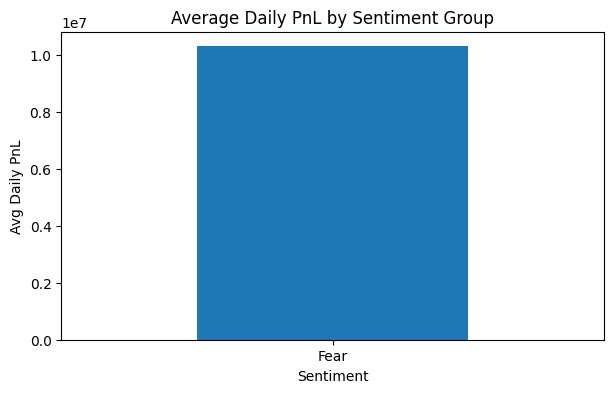

In [92]:
# Chart : Average Pnl by sentiment group
import matplotlib.pyplot as plt

plot_df = insight1_table.set_index("FG_group")["avg_daily_pnl"]

plt.figure(figsize=(7,4))
plot_df.plot(kind="bar")
plt.title("Average Daily PnL by Sentiment Group")
plt.ylabel("Avg Daily PnL")
plt.xlabel("Sentiment")
plt.xticks(rotation=0)
plt.show()


Insight 2. Traders trade more frequently during grid days

In [68]:
print(merged.columns)


Index(['date', 'daily_pnl', 'trades', 'avg_trade_size', 'wins', 'win_rate',
       'fear_value', 'fear_class', 'cum_pnl', 'rolling_peak', 'drawdown',
       'drawdown_pct_proxy', 'FG_group'],
      dtype='object')


In [69]:
# Insight-2
insight2_table = (
    merged.groupby("FG_group")
    .agg(
        avg_trades=("trades", "mean"),
        median_trades=("trades", "median"),
        avg_trade_size=("avg_trade_size", "mean")
    )
    .reset_index()
)

insight2_table


,FG_group,avg_trades,median_trades,avg_trade_size
0,Fear,211224.0,211224.0,5639.45121


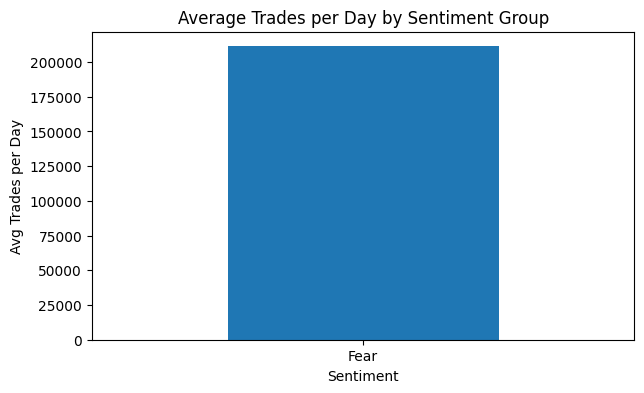

In [93]:
import matplotlib.pyplot as plt

plot_df = insight2_table.set_index("FG_group")["avg_trades"]

plt.figure(figsize=(7,4))
plot_df.plot(kind="bar")
plt.title("Average Trades per Day by Sentiment Group")
plt.ylabel("Avg Trades per Day")
plt.xlabel("Sentiment")
plt.xticks(rotation=0)
plt.show()


Insight 3. Long / Short daily ratio

In [76]:
print(merged["drawdown"].isna().sum(), "NaNs in drawdown")
print(merged["drawdown"].describe())
print(merged["FG_group"].value_counts(dropna=False))


0 NaNs in drawdown
count    1.0
mean     0.0
std      NaN
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: drawdown, dtype: float64
FG_group
Fear    1
Name: count, dtype: int64


In [83]:
print(hyperliquid["Side"].value_counts(dropna=False).head(20))


Side
SELL    108528
BUY     102696
Name: count, dtype: int64


In [84]:
print(ls_daily.columns)


Index(['date', 'BUY', 'SELL'], dtype='object', name='Side')


Normalize buy and sell

In [85]:
hyperliquid["Side_clean"] = hyperliquid["Side"].astype(str).str.strip().str.lower()

# Map common formats to Buy/Sell
hyperliquid["Side_clean"] = hyperliquid["Side_clean"].replace({
    "buy": "Buy",
    "sell": "Sell",
    "b": "Buy",
    "s": "Sell",
    "long": "Buy",
    "short": "Sell"
})


In [86]:
import numpy as np

ls_daily = (
    hyperliquid.groupby(["date", "Side_clean"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Ensure both columns exist
if "Buy" not in ls_daily.columns:
    ls_daily["Buy"] = 0
if "Sell" not in ls_daily.columns:
    ls_daily["Sell"] = 0

ls_daily["long_short_ratio"] = ls_daily["Buy"] / ls_daily["Sell"].replace(0, np.nan)

merged2 = merged.merge(ls_daily[["date", "long_short_ratio"]], on="date", how="left")
merged2.head()


,date,daily_pnl,trades,avg_trade_size,wins,win_rate,fear_value,fear_class,cum_pnl,rolling_peak,drawdown,drawdown_pct_proxy,FG_group,long_short_ratio
0,1970-01-01,1.029696e+07,211224,5639.45121,86869,0.411265,46.981089,Fear,1.029696e+07,1.029696e+07,0.0,0.0,Fear,0.946263


Long / Short ration by volume

In [89]:
ls_volume = (
    hyperliquid.groupby(["date", "Side_clean"])["Size USD"]
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)

if "Buy" not in ls_volume.columns:
    ls_volume["Buy"] = 0
if "Sell" not in ls_volume.columns:
    ls_volume["Sell"] = 0

ls_volume["long_short_ratio_volume"] = ls_volume["Buy"] / ls_volume["Sell"].replace(0, np.nan)

merged2 = merged2.merge(ls_volume[["date", "long_short_ratio_volume"]], on="date", how="left")


Long / Short ratio by sentiments

In [90]:
insight3_table = (
    merged2.groupby("FG_group")
    .agg(
        avg_long_short_ratio=("long_short_ratio", "mean"),
        median_long_short_ratio=("long_short_ratio", "median")
    )
    .reset_index()
)

insight3_table


,FG_group,avg_long_short_ratio,median_long_short_ratio
0,Fear,0.946263,0.946263


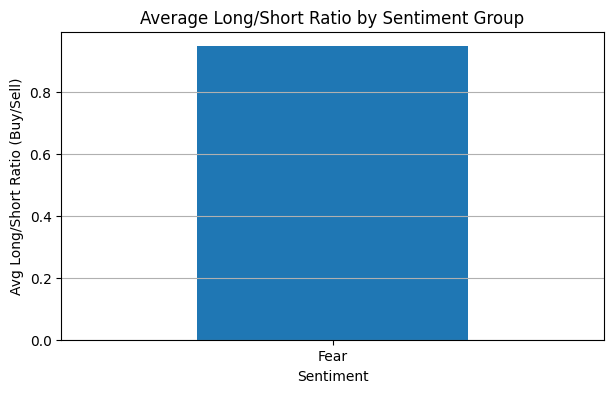

In [94]:
import matplotlib.pyplot as plt

plot_df = insight3_table.set_index("FG_group")["avg_long_short_ratio"]

plt.figure(figsize=(7,4))
plot_df.plot(kind="bar")
plt.title("Average Long/Short Ratio by Sentiment Group")
plt.ylabel("Avg Long/Short Ratio (Buy/Sell)")
plt.xlabel("Sentiment")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()
